# CS156 Assignment 4 

For this assignment, I'll be using the Image net data, specifically the man and woman images where I try to classify if a clothing is for man or woman. The data set consists of over 2,000 images and will be using PCA and LDA. 

Link to the working notebook can be accessed [here](https://github.com/lanceaquino/CS156-work-products-git/blob/main/cs156-assignment-4/cs156-assignment4-lance.ipynb). 

In [1]:
from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt

# create paths for all images
man_clothes = glob('man/*')
woman_clothes = glob('woman/*')

## Data Preprocessing

In [2]:
def image_resize(images, size):
    """
    This function is used from Session 7.1 where we use to 
    resize images.
    """
    flattened = []
    # for each image path
    for path in images:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                cover = resizeimage.resize_cover(image, size)
                # flatten the matrix to an array and append it to all flattened images
                flattened.append((np.array(cover).flatten(), 0))

    # Flatten it once more
    flattened = np.asarray(flattened, dtype = object)

    # Declare which are the X and Y inputs
    X = flattened[:,0]
    Y = flattened[:,1]

    # Use np.stack to put the data into the right dimension
    X = np.stack(i for i in X)
    Y = np.stack(i for i in Y)
    
    return X, Y


In [3]:
%%time

# chosen size reduction 
size = [50,150]

man_images = image_resize(man_clothes, size)[0]
woman_images = image_resize(woman_clothes, size)[0]

#Check data shape 
print(man_images.shape) 
print(woman_images.shape) 

/Users/lancelot/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/execution.py:1321: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code, glob, local_ns)


(1242, 22500)
(1270, 22500)
CPU times: user 11.6 s, sys: 345 ms, total: 12 s
Wall time: 12.1 s


#### NOTE 

This error can be ignored since we do not need to implement the function again and that we have the desired dimensions. 

In [4]:
## Add classes and merge data 

# Add 1 for men and 0 for women classes 
new_column_ones = np.ones((len(man_images), 1))
new_column_zeros = np.zeros((len(woman_images), 1))

class_man_images = np.append(man_images, new_column_ones, axis = 1)
class_woman_images = np.append(woman_images, new_column_zeros, axis = 1)

print(class_man_images.shape)
print(class_woman_images.shape)

images_data = np.concatenate((class_man_images, class_woman_images), axis = 0)

print(images_data.shape)

(1242, 22501)
(1270, 22501)
(2512, 22501)


In [5]:
from sklearn.model_selection import train_test_split

X = images_data[:, 0:-1] # select all except the last column 
y = images_data[:, -1] # select last column 

print(X.shape)
print(y.shape)

# Splitting training and testing for 80% and 20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

print("Split data: ")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(2512, 22500)
(2512,)
Split data: 
(2009, 22500)
(503, 22500)
(2009,)
(503,)


## Using Logistic Regression without PCA or LDA 

In [6]:
from sklearn.linear_model import LogisticRegression 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [7]:
%%time 

logregCV = make_pipeline(StandardScaler(), 
                         LogisticRegressionCV(cv = 5, random_state = 0, tol = 1))

# Fit values
logregCV.fit(X_train, y_train)

# Acquire Metrics 
logregCV_training_score = logregCV.score(X_train, y_train)
logregCV_testing_score = logregCV.score(X_test, y_test)

print("---SCORES---")
print("Training Score:", logregCV_training_score)
print("Testing Score:", logregCV_testing_score)

---SCORES---
Training Score: 0.75311100049776
Testing Score: 0.6302186878727635
CPU times: user 6min 58s, sys: 22.6 s, total: 7min 21s
Wall time: 44.7 s


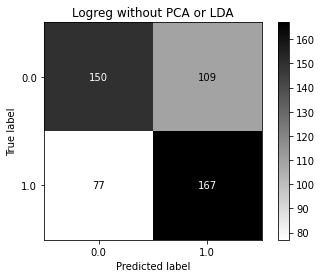

In [8]:
# Plot confusion metrics 
metrics.plot_confusion_matrix(logregCV, X_test, y_test, cmap = 'binary')
plt.title("Logreg without PCA or LDA")
plt.show()

## Logistic Regression with PCA 

As the first step, we would just like to check on how the trend of the scree plot behaves when we apply PCA. Here we just test up until 20 n_components since beyond that would just be purely flat variance and would be really small to see. 

Data shape: (2009, 20) (503, 20)


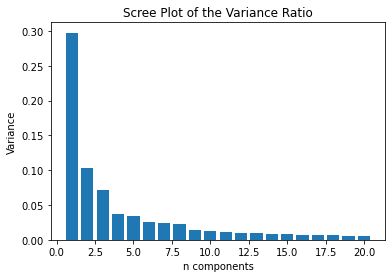

In [9]:
# Checking how PCA works out on the scree plot 
from sklearn import decomposition

# We will by looking at how much variance we get 
n_components = 20

pca = decomposition.PCA(n_components = n_components)
X_PCA_train = pca.fit_transform(X_train)
X_PCA_test = pca.fit_transform(X_test)

print("Data shape:", X_PCA_train.shape, X_PCA_test.shape)

# Plot the variance on a scree plot 
def plot_scree(n_comp, pca_var):
    plt.bar(np.linspace(1, n_comp, n_comp),pca_var)

    plt.title("Scree Plot of the Variance Ratio")
    plt.xlabel("n components")
    plt.ylabel("Variance")

    plt.show()
    
plot_scree(n_components, pca.explained_variance_ratio_)



#### Using multiple n_comps 

Here, we trying to measure the training and testing score using different n_comps for our PCA and logreg. 

In [10]:
def PCA_logreg_metrics(X_train, X_test, y_train, y_test, n_comps): 
    """
    This function aims to check on the training and testing 
    scores with varying n_commponents set for the PCA. 
    
    Input: data 
    Output: Training and testing scores 
    """
    # Metrics 
    training_scores = []
    testing_scores = []
    
    for n in n_comps: 
        # Fit PCA 
        pca = decomposition.PCA(n_components = n)
        X_PCA_train = pca.fit_transform(X_train)
        X_PCA_test = pca.fit_transform(X_test)
        
        # Fit LogReg 
        logreg = LogisticRegression(max_iter=100)
        logreg.fit(X_PCA_train, y_train)
        
        training_scores.append(logreg.score(X_PCA_train, y_train))
        testing_scores.append(logreg.score(X_PCA_test, y_test))
        
    return training_scores, testing_scores 

In [ ]:
%%time 

# Get number of components from 1 to 99 
n_comps = np.linspace(1, 49, 49).astype('int64')

training_scores, testing_scores = PCA_logreg_metrics(X_train, X_test, y_train, y_test, n_comps)

In [ ]:
# Plot results 

fig, ax = plt.subplots(1,2, figsize = [15,5])

ax[0].plot(n_comps, training_scores, label = 'training')
ax[0].plot(n_comps, testing_scores, label = 'testing')
ax[0].set_title("Training vs Testing scores using PCA")
ax[0].set_xlabel("n_components")
ax[0].set_ylabel("score")
ax[0].legend()

ax[1].plot(n_comps[0:15], training_scores[0:15], label = 'training')
ax[1].plot(n_comps[0:15], testing_scores[0:15], label = 'testing')
ax[1].set_title("Training vs Testing scores using PCA (Zoomed in)")
ax[1].set_xlabel("n_components")
ax[1].set_ylabel("score")
ax[1].legend()
plt.show()


**NOTES**

0 - 10: good measure of n_components with high testing score 

15 and beyond: starting to overfit 

### Best PCA parameters

Based on the plot, I tried on different n_comps between 1-15 since it has the highest pair of training and testing scores. I ended up with 5. 

In [ ]:
# We will by looking at how much variance we get 
n_components = 5

pca = decomposition.PCA(n_components = n_components)
X_PCA_train = pca.fit_transform(X_train)
X_PCA_test = pca.fit_transform(X_test)

logreg_PCA = LogisticRegression(max_iter=100)

logreg_PCA.fit(X_PCA_train, y_train)

logreg_pred = logreg_PCA.predict(X_PCA_test)

# Acquire Metrics 
logreg_PCA_training_score = logreg_PCA.score(X_PCA_train, y_train)
logreg_PCA_testing_score = logreg_PCA.score(X_PCA_test, y_test)

print("---SCORES---")
print("Training Score:", logreg_PCA_training_score)
print("Testing Score:", logreg_PCA_testing_score)

In [ ]:
# Plot confusion matrix 
metrics.plot_confusion_matrix(logreg_PCA, X_PCA_test, y_test, cmap = 'binary')
plt.title("Logreg with PCA")
plt.show()

#### Experimenting PCA with CV 

Based on the observations in the graph, we noticed that the data tends to overfit once we increase the number of components. With n_comp higher than 400, the testing score reaches over 0.9 and testing score is approx. 0.5. I experimented with using this n_comp and performing CV with the LogReg model using PCA-transformed X_train and X_test and did not see any improvements. The mode had a less overfit but with a low testing score (training = 0.7, testing = 0.54). 

I did not paste the code here anymore since I considered this as exploratory and will not be used for the analysis

## Logistic Regression with LDA 

In [ ]:
# Implement LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [ ]:
%%time

# Fitting LDA 
lda = LinearDiscriminantAnalysis()

X_LDA_train = lda.fit_transform(X_train, y_train)
X_LDA_test = lda.transform(X_test)


In [ ]:
# See how our LDA performs 

fig, ax = plt.subplots(1,2, figsize = [15,5])

ax[0].hist(X_LDA_train)
ax[0].set_title(f"Training with LDA score {lda.score(X_train,y_train)}") 
ax[0].set_xlabel("X_LDA values")
ax[1].hist(X_LDA_test)
ax[1].set_title(f"Testing with LDA score {lda.score(X_test,y_test)}")
ax[1].set_xlabel("X_LDA values")

plt.show()

In [ ]:
# Implementing with LogReg 

logreg_LDA = LogisticRegressionCV()

# Tried using CV and still does not change anything. 
# logreg_LDA = LogisticRegressionCV(cv = 10, random_state = 0)

logreg_LDA.fit(X_LDA_train, y_train)

logreg_pred = logreg_LDA.predict(X_LDA_test)

# Acquire Metrics 
logreg_LDA_training_score = logreg_LDA.score(X_LDA_train, y_train)
logreg_LDA_testing_score = logreg_LDA.score(X_LDA_test, y_test)

print("---SCORES---")
print("Training Score:", logreg_LDA_training_score)
print("Testing Score:", logreg_LDA_testing_score)

### NOTE 

For the LDA model, I also performed a validation stepped where I tried different regularization parameters but it does not change the training and testing score and it is always equal to the LDA training and testing score after fitting to the logistic regression. I also attempted to apply the same process in linear SVM but the results were the same. Therefore, the LDA tends to overfit with the training data and resulting in a worse classification 

In [ ]:
# Plot confusion matrix 
metrics.plot_confusion_matrix(logreg_LDA, X_LDA_test, y_test, cmap  = 'binary')
plt.title("Logreg with LDA")
plt.show()

## Summary of Analysis 


For this analysis, we will be looking at the confusion matrices and the scores of each of the model for comparison. 

In [ ]:
fig, axes = plt.subplots(1,3, figsize = [20,5])

classifiers = [logregCV, logreg_PCA, logreg_LDA]
titles = ['LogReg', 'LogReg with PCA', 'LogReg with LDA'] 
X = [X_test, X_PCA_test, X_LDA_test]

counter = 0 
for cls, ax in zip(classifiers, axes.flatten()):
    metrics.plot_confusion_matrix(cls, 
                          X[counter], 
                          y_test, 
                          ax=ax, 
                          cmap='Blues')
    ax.set_title(titles[counter])
    counter += 1 
plt.show() 


### Training and Testing Scores Table 

|                | LogRegCV | LogReg with PCA  | LogReg with LDA |
|----------------|--------|------------------|-----------------|
| Training Score | 0.7531 | 0.6302           | 0.9990          |
| Testing Score  | 0.6302 | 0.6004           | 0.5547          |

### Confusion Matrix

A common occurrence for all models is the error in predicting male clothing where a majority of the images for the male clothing is categorized as female. A main reason for this problem is perhaps the noise in the male data set where some pictures have females in them and is very noisy in terms of the type of photo. Some photos are group photos of people wearing multiple clothes. To improve this, we might want to clean out the data set and select the only ones that can represent clothes only and not other individuals or other variables that are present in the photos. For all models, they seem to have more correct predictions that errors which is a good sign and the best model that is performing is the Logistic regression with the PCA. 


### Training and Testing Scores 

**BEST MODEL: Logistic Regression**

For the logistic regression, we performed a cross-validation step since our logistic regression tends to overfit when n_features > n_samples of the data. After optimizing for the regularization parameter, Logistic Regression with CV is the best model compared to LogReg with PCA or LDA with the highest testing score. Compared to LogReg with PCA based on the confusion matrix, it performs slightly better in classifying male clothing photos with regards to correct classification. 

**Logistic Regression with the PCA** 

The application of PCA to the Logistic regression comes second in this analysis. First, I look into the scree plot to see how the number of components change the variation captured by the transformation. Then, I tried different n_comps to transform the data set. Looking back to that plot, the model seems to improve itself as we increase the number of components from 1 to 10. Beyond that number of components, the model starts to overfit and its testing scores are significantly diminished. Even after using CV at higher dimensions, the testing score cannot be improved. Our best n_comp value = 5 and the results are shown in the table above. 

**Logistic Regression with LDA** 

Applying LDA to the model and using logistic regression seemed to overfit the training data by alot with a training score of almost 1. The testing score 0.55 is worse makes it the worst model for this analysis. I also tried using a validation step but changing the regularization parameter doesn't seem to change the training and testing score. I also tried using the Linear SVM instead of a logistic regression and the training and testing scores are still the same.


### Recommendations 

Based on our results, the logistic regression with cross validation (LogRegCV) is our best bet in doing the job for classifying male and female clothing since it has the best testing score and does not overfit. With specific adjustments to the logistic regression for its tolerance and standardizing the data, we are able to perform a good classification model despite a very noisy data set. 

However, this is only for our own data set and we must take note that we performed resizing in our images and that our data set is very noisy. Other improvements would be cleaning our data and checking for photos that do not really represent the proper class that we are aiming for (some photos are just group photos of people with both male and female individuals included). 

Lastly, we can also consider using other models such as LinearSVM and KNN since Logistic Regression's disadvantage is overfitting when n_features > n_samples. We needed to increase its tolerance for convergence and may have affected with the accuracy of our predictions. 